 example to Daniel Moller - https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/40881
 ideas and comments are wellcode

In [1]:
import numpy as np  # numeric library
import pandas as pd # read file, and use dataframes (like database tables, but in python)
# read train file (train have features (X vectors) and target (Y vectors)), you use it to fit models
train  =pd.read_csv("../input/train.csv")
print(train.columns)   # show columns at train pandas.DataFrame
print(np.shape(train)) # show DataFrame shape (~= rows, features)

#this variable will contain an 'array' of all feature columns, i will use it to train model
col = train.columns.drop(['id','target'])


Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [2]:
#in this competition we use GINI metric as 'evaluation function'
# there're 2 metrics, error functions - used to fit models (normally they are differentiable)
#                and evaluation functions - used to select / check what's the useful metric information

# i will show an XGBoost model classifier, it's an gradient boosted , it will use logloss to train, in this case
# it will use logloss as error function, and evaluation function is just to check if model is doing a good work
# XGBoost have others methods to crossvalidate it, 
# but i will show an 'generic' estimator CV scoring idea using scikit learn lib






#let's implement the evaluation function:
from sklearn.metrics import make_scorer #function to create a scorer from an metric function
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score
# i will create an SCORER to use with SCIKIT LEARN library
gini_scorer = make_scorer(gini_normalized, greater_is_better = True)

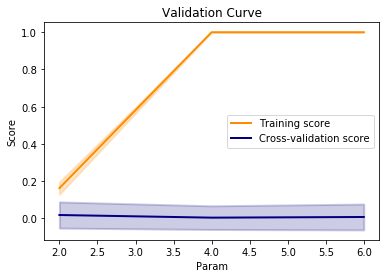

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import validation_curve,StratifiedShuffleSplit
#let's create a model (xgb_model variable) using some 'default' parameters
xgb_model = XGBClassifier(
    n_jobs=-1,
    objective='binary:logistic',
    learning_rate=1,
    max_depth=2,
    silent=False,
    subsample=1,
    colsample_bytree=1,
    n_estimators=100,
    random_state=1
)

#i will naive reduce dataset size cause validation_curve is a bit cpu intensive (that's not ok, just an example)
# you should check if you can do it, and how, with your model+dataset or not
some_sample_data_to_test=train.sample(n=10000)

# let's do some fitting, using different parameters and plot what's the crossvalidation score:
param_range=[2,4,6]
train_scores, test_scores = validation_curve( #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html
    xgb_model,       #model that we will fit many many times (crossvalidate) with different parameters
    some_sample_data_to_test[col],      #features
    some_sample_data_to_test['target'], #target variable 
    param_name="max_depth",       #parameter that we will change
    param_range=param_range,      #values that we will change
    cv=StratifiedShuffleSplit(5,random_state=1,test_size=.1),  # CV SPLIT STRATEGY, here we select how to cut data and validation_curve function will execute crossvalidation scoring
    scoring=gini_scorer,#"neg_log_loss",    #score function
    n_jobs=-1)

# get scorer values
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

#plot some chart
import matplotlib.pyplot as plt
plt.title("Validation Curve")
plt.xlabel("Param")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#more explanation about bias-variance: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py
#T. Hastie, R. Tibshirani and J. Friedman, “Elements of Statistical Learning”, Springer, 2009.

#check that training score is high (in-sample data) - the model overfit in sample
#check that test score is lower (out-of-sample data) - the model don't generalize to the out-of-sample 
#                                                      data (bad estimator ~ wrong hyperparameters or wrong model, or poor dataset ~ poor features or intratable problem)
#
#the crossvalidation idea is test model with diferent train-test data (folds / cuts), 
#and have a 'good' crossvalidation score (good bias/variance), good crossvalidation ~= good generalization ~= good models

In [4]:
# you can use cross_val_score too, it just train-test and return scores, no validation curve

from sklearn.model_selection import cross_val_score #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score


xgb_model = XGBClassifier(
    n_jobs=-1,
    objective='binary:logistic',
    learning_rate=1,
    max_depth=2,
    silent=False,
    subsample=1,
    colsample_bytree=1,
    n_estimators=100,
    random_state=1
)

some_sample_data_to_test=train.sample(n=10000)

print(
    'score for each kfold, using cross_val_score function:',
    cross_val_score(xgb_model, 
                          X=some_sample_data_to_test[col], 
                          y=some_sample_data_to_test['target'],
                          scoring=gini_scorer,
                          cv=StratifiedShuffleSplit(5,random_state=1,test_size=.1)
     ) ) 

score for each kfold, using cross_val_score function: [ 0.0376906  -0.07754256  0.0857735  -0.08032568  0.12757957]


In [5]:
# what StratifiedShuffleSplit do?
cv=StratifiedShuffleSplit(5,random_state=1,test_size=.1)

#some_sample_data_to_test=train.sample(n=10000).copy()   #copy dataset 
#some_sample_data_to_test.reset_index(drop=True,inplace=True) #reset index

X=some_sample_data_to_test[col]
y=some_sample_data_to_test['target']
print('splits using CV functions->',cv.get_n_splits(X,y))

#it create an generator object that return (X,y) slices to train-test
i=0
for train_index, test_index in cv.split(X,y):
    if(False): #change to true to check index selected at each fold
        print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] #cut data - X
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] #cut data - Y
    
    #fit your model
    xgb_model.fit(X_train,y_train)
    #score it (that's what cross_val_score do)
    print('cv split',i,' score=',gini_normalized(y_test,xgb_model.predict_proba(X_test)[:,1]))
    i+=1
    
#if your model have a good bias/variance tradeoff in crossvalidation, you can fit you model 
# with all data:

xgb_model.fit(some_sample_data_to_test[col],some_sample_data_to_test['target'])

#and predict any other new data
predict  =pd.read_csv("../input/test.csv") #reading test data

xgb_model.predict_proba(predict[col])[:,1]  #[:,1] select only positive (true) probabilities

splits using CV functions-> 5
cv split 0  score= 0.0118134715026
cv split 1  score= -0.0328349370836
cv split 2  score= 0.0494152479645
cv split 3  score= -0.215455218357
cv split 4  score= 0.08044411547


array([ 0.0007539 ,  0.00569175,  0.01687879, ...,  0.06021884,
        0.00591341,  0.00441474], dtype=float32)

good luck!